In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


# CONFIG

DATA_PATH = "C:/Users/Bandi Neha/Downloads/heart.csv"   
TARGET_COL = "target"

TEST_SIZE = 0.2
VAL_SIZE = 0.2
RANDOM_STATE = 42


In [9]:

# 1. LOAD DATA

def load_data(path, target_col):
    df = pd.read_csv(path)
    print("Shape of dataset:", df.shape)
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nTarget value counts:")
    print(df[target_col].value_counts())
    return df

In [10]:
# 2. SPLIT DATA

def split_data(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=TEST_SIZE,
        stratify=y,
        random_state=RANDOM_STATE
    )

    val_ratio = VAL_SIZE / (1 - TEST_SIZE)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=1 - val_ratio,
        stratify=y_temp,
        random_state=RANDOM_STATE
    )

    print("\nSplit sizes:")
    print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [11]:
# 3. SCALING

def scale_data(X_train, X_val, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return scaler, X_train_scaled, X_val_scaled, X_test_scaled


In [12]:
# 4. TRAIN LOGISTIC REGRESSION

def train_logistic_regression(X_train, y_train, X_val, y_val):
    print("\n===== Training Logistic Regression =====")

    param_grid = {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs"],
        "max_iter": [1000]
    }

    lr = LogisticRegression()
    grid = GridSearchCV(
        lr,
        param_grid,
        scoring="f1",
        cv=5,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_lr = grid.best_estimator_
    print("Best LR params:", grid.best_params_)

    y_val_pred = best_lr.predict(X_val)
    print("\nValidation Classification Report (Logistic Regression):")
    print(classification_report(y_val, y_val_pred))

    return best_lr

In [13]:
# 5. TRAIN RANDOM FOREST

def train_random_forest(X_train, y_train, X_val, y_val):
    print("\n===== Training Random Forest =====")

    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
    }

    rf = RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced"
    )

    grid = GridSearchCV(
        rf,
        param_grid,
        scoring="f1",
        cv=5,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_rf = grid.best_estimator_
    print("Best RF params:", grid.best_params_)

    y_val_pred = best_rf.predict(X_val)
    print("\nValidation Classification Report (Random Forest):")
    print(classification_report(y_val, y_val_pred))

    return best_rf



In [14]:
# 6. EVALUATION

def evaluate_model(name, model, X_test, y_test, proba_available=True):
    print(f"\n===== Test Performance: {name} =====")
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    if proba_available:
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        roc_auc = np.nan

    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1-score :", f1)
    print("ROC-AUC  :", roc_auc)

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    if proba_available and y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"ROC Curve - {name}")
        plt.show()

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc
    }


In [15]:
# 7. SIMPLE EXPLAINABILITY

def explain_logistic_regression(model, feature_names):
    print("\n===== Logistic Regression Coefficients (Feature Effects) =====")
    coefs = model.coef_[0]
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coefficient": coefs
    }).sort_values(by="coefficient", ascending=False)
    print(coef_df)

    plt.figure()
    plt.barh(coef_df["feature"], coef_df["coefficient"])
    plt.xlabel("Coefficient")
    plt.title("Logistic Regression Feature Effects")
    plt.gca().invert_yaxis()
    plt.show()


def explain_random_forest(model, feature_names):
    print("\n===== Random Forest Feature Importances =====")
    importances = model.feature_importances_
    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)
    print(imp_df)

    plt.figure()
    plt.barh(imp_df["feature"], imp_df["importance"])
    plt.xlabel("Importance")
    plt.title("Random Forest Feature Importances")
    plt.gca().invert_yaxis()
    plt.show()

Shape of dataset: (1025, 14)

First 5 rows:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  

Target value counts:
target
1    526
0    499
Name: count, dtype: int64

Split sizes:
Train: (820, 13) Val: (51, 13) Test: (154, 13)

===== Training Logistic Regression =====
Best LR params: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

Validation Classification Report (Logistic Regression):
              precision  

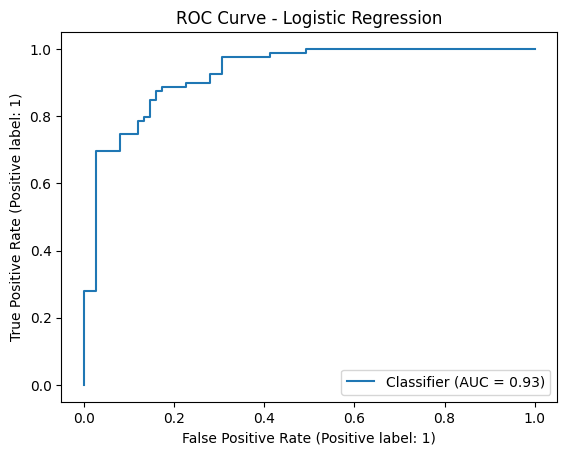


===== Test Performance: Random Forest =====
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0
ROC-AUC  : 1.0

Confusion Matrix:
[[75  0]
 [ 0 79]]


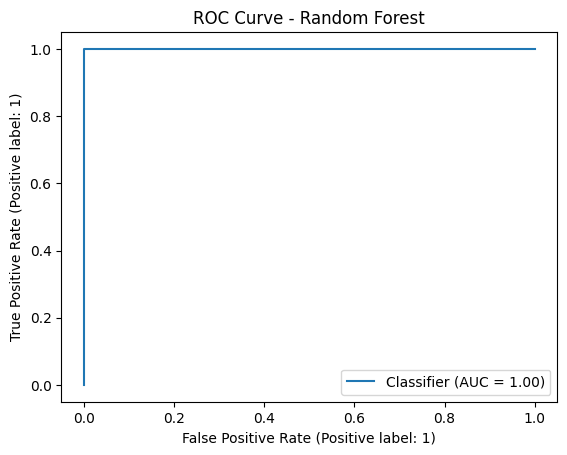


===== MODEL COMPARISON (Test Set) =====
                 model  accuracy  precision    recall        f1   roc_auc
0  Logistic Regression  0.818182   0.774194  0.911392  0.837209  0.927932
1        Random Forest  1.000000   1.000000  1.000000  1.000000  1.000000

===== Logistic Regression Coefficients (Feature Effects) =====
     feature  coefficient
2         cp     0.867323
7    thalach     0.413731
10     slope     0.366364
6    restecg     0.162857
5        fbs    -0.016096
0        age    -0.115252
4       chol    -0.276077
3   trestbps    -0.363176
12      thal    -0.499081
8      exang    -0.516893
9    oldpeak    -0.612114
11        ca    -0.745955
1        sex    -0.782139


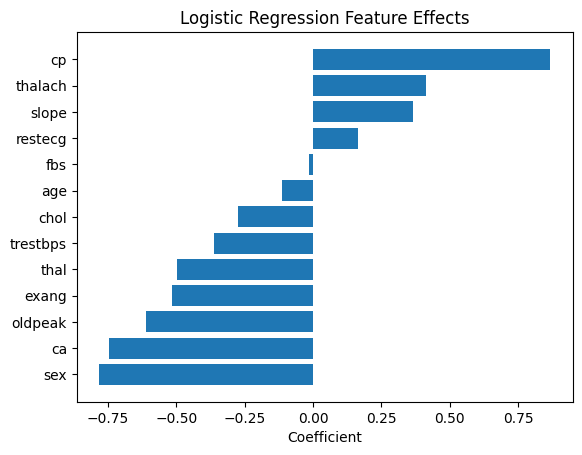


===== Random Forest Feature Importances =====
     feature  importance
2         cp    0.145423
7    thalach    0.116016
11        ca    0.110512
9    oldpeak    0.101898
0        age    0.099942
12      thal    0.098958
8      exang    0.076348
4       chol    0.074288
3   trestbps    0.070697
10     slope    0.044492
1        sex    0.033861
6    restecg    0.017209
5        fbs    0.010355


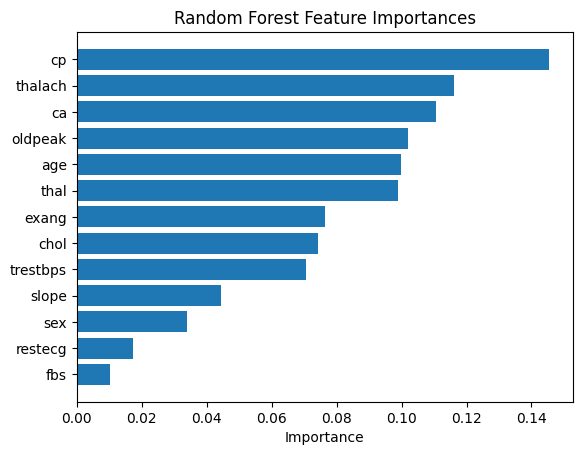

In [16]:
# 8. MAIN

def main():
    df = load_data(DATA_PATH, TARGET_COL)

    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, TARGET_COL)
    feature_names = X_train.columns.tolist()

    scaler, X_train_scaled, X_val_scaled, X_test_scaled = scale_data(
        X_train, X_val, X_test
    )

    best_lr = train_logistic_regression(
        X_train_scaled, y_train, X_val_scaled, y_val
    )

    best_rf = train_random_forest(
        X_train, y_train, X_val, y_val
    )

    results = []
    res_lr = evaluate_model(
        "Logistic Regression",
        best_lr,
        X_test_scaled,
        y_test,
        proba_available=True
    )
    results.append(res_lr)

    res_rf = evaluate_model(
        "Random Forest",
        best_rf,
        X_test,
        y_test,
        proba_available=True
    )
    results.append(res_rf)

    print("\n===== MODEL COMPARISON (Test Set) =====")
    results_df = pd.DataFrame(results)
    print(results_df)

    # Simple interpretability
    explain_logistic_regression(best_lr, feature_names)
    explain_random_forest(best_rf, feature_names)


if __name__ == "__main__":
    main()
